In [632]:
from torch.utils.data import random_split
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import torch


epochs=200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
def load_tu_data(dataset_name='PROTEINS', use_node_attr=True, initial_per_class=50):
    dataset = TUDataset(root='/tmp/' + dataset_name, name=dataset_name, use_node_attr=use_node_attr)

    num_classes = dataset.num_classes
    num_node_features = dataset.num_features
    
    class_counters = {i: 0 for i in range(num_classes)}
    initial_indices = []
    indices = torch.randperm(len(dataset))
    
    for idx in indices:
        label = dataset[idx].y.item()
        if(class_counters[label]<initial_per_class):
            initial_indices.append(idx)
            class_counters[label]+=1
        if all(count >= initial_per_class for count in class_counters.values()):
            break

    remaining_indices = [i for i in indices if i not in initial_indices]
    num_totalinit = len(remaining_indices)
    num_train = int(num_totalinit * 0.3)
    num_val = int(num_totalinit * 0.1)
    num_test = int(num_totalinit * 0.1)
    num_pool = num_totalinit - num_train - num_val - num_test

    train_indices = remaining_indices[:num_train]
    val_indices = remaining_indices[num_train:num_train + num_val]
    test_indices = remaining_indices[num_train + num_val:num_train + num_val + num_test]
    pool_indices = remaining_indices[num_train + num_val + num_test:]

    return dataset, initial_indices, train_indices, val_indices, test_indices, pool_indices, num_classes, num_node_features


Using device: cuda


Indice alapján Data Loader

In [633]:
def create_data_loader(dataset, indices, batch_size=10, shuffle=True):
    subset = torch.utils.data.Subset(dataset, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle)

def update_indices(train_indices, pool_indices, selected_pool_indices):
    """
    Update training and pool indices after selecting some indices from the pool.
    
    Args:
        train_indices (list): Current list of training indices.
        pool_indices (list): Current list of pool indices.
        selected_pool_indices (list): Indices selected from the pool to be moved to training.
    
    Returns:
        tuple: Updated lists of train and pool indices.
    """
    # Ensure all are lists
    train_indices = list(train_indices)
    selected_pool_indices = list(selected_pool_indices)

    # Add selected indices to train indices
    new_train_indices = train_indices + selected_pool_indices

    # Remove the selected indices from pool indices
    new_pool_indices = [idx for idx in pool_indices if idx not in selected_pool_indices]

    return new_train_indices, new_pool_indices



In [634]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool


class GNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=256):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = torch.nn.functional.dropout(x, p=0.25, training=True)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch.nn.functional.dropout(x, p=0.5, training=True)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch.nn.functional.dropout(x, p=0.5, training=True)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch.nn.functional.dropout(x, p=0.5, training=True)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch.nn.functional.dropout(x, p=0.5, training=True)
        # Global mean pooling
        x = global_mean_pool(x, batch)  # Aggregate node features to graph features
        x = self.out(x)
        return F.log_softmax(x, dim=1)

Uniform Acquisition function

In [635]:
import numpy as np

def uniform(model, dataset, pool_indices, n_query, T=100, training=True):
    """
    Uniformly random selection of data points from the unlabeled pool.
    
    Args:
    pool_indices (list): List of indices available in the pool.
    n_query (int): Number of queries to make.
    
    Returns:
    list: Indices of the selected data points.
    """
    # Directly use the pool_indices to select data points
    selected_indices = np.random.choice(pool_indices, size=n_query, replace=False)
    
    return selected_indices.tolist()


Initial training

In [636]:

def create_initial_data_loader(dataset, num_initial, batch_size=10):
    indices = torch.randperm(len(dataset))[:num_initial]
    subset = torch.utils.data.Subset(dataset, indices.tolist())
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    return loader, indices


def train_initial_model(model, data_loader, val_loader, epochs, optimizer, criterion, device):
    faccuracies = []
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        val_acc = evaluate_model(model, val_loader)
        accuracies.append(val_acc)
            
        if epoch % 10 == 0:
            print(f'Initial Training Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(data_loader)}')
    return faccuracies

Active learning loop

In [637]:
def active_learning_loop(model, dataset, initial_indices, train_indices, pool_indices, val_indices, test_indices, query_strategy, n_query=10, epochs=100):
    accuracies = []
    initial_loader = create_data_loader(dataset, initial_indices, batch_size=10)   
    train_loader = create_data_loader(dataset, train_indices)
    val_loader = create_data_loader(dataset, val_indices, shuffle=False)
    test_loader = create_data_loader(dataset, test_indices, shuffle=False)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
    criterion = torch.nn.CrossEntropyLoss()
    swag=train_initial_model(model, initial_loader, val_loader, 50, optimizer, criterion, device)
    accuracies=swag

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        num_batches = 0

        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_batches += 1
             
        train_loss /= num_batches
        val_acc = evaluate_model(model, val_loader)
        accuracies.append(val_acc)
        

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}')
            selected_indices = query_strategy(model, dataset, pool_indices, n_query, T=100, training=True)
            print(f'Selected indices for training: {selected_indices}')
            train_indices, pool_indices = update_indices(train_indices, pool_indices, selected_indices)
            print(f'Updated train indices count: {len(train_indices)}, Pool indices count: {len(pool_indices)}')
            train_loader = create_data_loader(dataset, train_indices)  # Recreate the loader with updated indices

    test_acc = evaluate_model(model, test_loader)
    print(f'Final Test Accuracy: {test_acc:.4f}')
    accuracies.append(test_acc)
    return accuracies


Eval

In [638]:

def evaluate_model(model, loader):
    correct = 0
    total = 0
    for batch in loader:
        batch.to(device) # Ensure labels are also moved
        out = model(batch)
        pred = out.max(dim=1)[1]
        correct += pred.eq(batch.y).sum().item()
        total += batch.num_graphs
        
    return correct / total

def update_loaders(train_loader, pool_loader, new_data_indices, pool_indices, train_indices):
    # Add new data indices to train indices
    for idx in new_data_indices:
        train_indices.append(pool_indices[idx])

    # Remove the selected indices from pool indices
    new_pool_indices = [idx for i, idx in enumerate(pool_indices) if i not in new_data_indices]

    # Update datasets and loaders
    train_loader.dataset.indices = train_indices
    pool_loader.dataset.indices = new_pool_indices

In [646]:
dataset, initial_indices, train_indices, val_indices, test_indices, pool_indices, num_classes, num_node_features = load_tu_data()
model = GNN(num_node_features, num_classes).to(device)
uniform_acc=active_learning_loop(model, dataset, initial_indices,train_indices, pool_indices, val_indices, test_indices, uniform, epochs=epochs)

Initial Training Epoch 1/50, Loss: 0.7017063975334168
Initial Training Epoch 11/50, Loss: 0.692665946483612
Initial Training Epoch 21/50, Loss: 0.6850491762161255
Initial Training Epoch 31/50, Loss: 0.6923791527748108
Initial Training Epoch 41/50, Loss: 0.6836902678012848
Epoch: 0, Train Loss: 0.6769, Val Accuracy: 0.6040
Selected indices for training: [570, 547, 683, 679, 543, 737, 538, 120, 839, 732]
Updated train indices count: 313, Pool indices count: 498
Epoch: 10, Train Loss: 0.6549, Val Accuracy: 0.5050
Selected indices for training: [950, 506, 943, 1091, 103, 736, 439, 960, 13, 972]
Updated train indices count: 323, Pool indices count: 488
Epoch: 20, Train Loss: 0.6505, Val Accuracy: 0.6436
Selected indices for training: [514, 544, 253, 73, 248, 88, 238, 516, 523, 486]
Updated train indices count: 333, Pool indices count: 478
Epoch: 30, Train Loss: 0.6370, Val Accuracy: 0.6139
Selected indices for training: [666, 65, 533, 540, 537, 113, 925, 788, 804, 546]
Updated train indices

Max Entropy Acquisition function

In [640]:
def predictions_from_pool(model, dataset, pool_indices, T=100, training=True):
    """
    Run MC dropout prediction on model using graphs from the pool and return the output.
    """
    # Randomly select indices from the pool
    random_subset = np.random.choice(pool_indices, size=min(2000, len(pool_indices)), replace=False)
    
    # Fetch the actual graph data from the dataset
    subset_loader = DataLoader(dataset[random_subset.tolist()], batch_size=len(random_subset), shuffle=False)
    batch = next(iter(subset_loader))  # Load the batch
    
    # Perform prediction
    outputs = []
    with torch.no_grad():
        for _ in range(T):
            batch.to(device)
            model.train(training)  # Enable/disable dropout
            output = torch.softmax(model(batch), dim=-1)
            outputs.append(output.cpu().numpy())
    outputs = np.stack(outputs)
    print("outputs shape: ",outputs.shape)
    
    return outputs, random_subset

def shannon_entropy_function(model, dataset, pool_indices, T=100, E_H=False, training=True):
    """
    Compute the Shannon entropy and optionally E_H if needed for BALD.
    """
    outputs, random_subset = predictions_from_pool(model, dataset, pool_indices, T, training)
    pc = outputs.mean(axis=0)
    H = (-pc * np.log(pc + 1e-10)).sum(axis=-1)  # Prevent log(0)

    if E_H:
        E = -np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)
        return H, E, random_subset
    return H, random_subset

def max_entropy(model, dataset, pool_indices, n_query=10, T=100, training=True):
    """
    Choose pool points that maximize the predictive entropy.
    """
    acquisition, random_subset = shannon_entropy_function(model, dataset, pool_indices, T, training=training)
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx


Training with Max Entropy

In [641]:
dataset, initial_indices, train_indices, val_indices, test_indices, pool_indices, num_classes, num_node_features = load_tu_data()
model = GNN(num_node_features, num_classes).to(device)
max_entropy_acc=active_learning_loop(model, dataset, initial_indices, train_indices, pool_indices, val_indices, test_indices, max_entropy, epochs=epochs)

Initial Training Epoch 1/50, Loss: 0.6988263905048371
Initial Training Epoch 11/50, Loss: 0.6962935209274292
Initial Training Epoch 21/50, Loss: 0.6923865914344788
Initial Training Epoch 31/50, Loss: 0.6908741176128388
Initial Training Epoch 41/50, Loss: 0.6923012554645538
Epoch: 0, Train Loss: 0.6582, Val Accuracy: 0.6535
outputs shape:  (100, 508, 2)
Selected indices for training: [ 763 1112  770  930 1044  354  916  471  831  614]
Updated train indices count: 313, Pool indices count: 498
Epoch: 10, Train Loss: 0.6499, Val Accuracy: 0.6535
outputs shape:  (100, 498, 2)
Selected indices for training: [ 973  454  305  753  672   75 1006 1025  497  547]
Updated train indices count: 323, Pool indices count: 488
Epoch: 20, Train Loss: 0.6337, Val Accuracy: 0.6535
outputs shape:  (100, 488, 2)
Selected indices for training: [1002 1045  745  498  919 1110  450  727  922  961]
Updated train indices count: 333, Pool indices count: 478
Epoch: 30, Train Loss: 0.6457, Val Accuracy: 0.7426
output

BALD Acquisition function

In [642]:
def bald(model, dataset, pool_indices, n_query=10, T=100, training=True):
    """Choose pool points that are expected to maximise the information
    gained about the model parameters, i.e. maximise the mutal information
    between predictions and model posterior. Given
    I[y,w|x,D_train] = H[y|x,D_train] - E_{p(w|D_train)}[H[y|x,w]]
    with w the model parameters (H[y|x,w] is the entropy of y given w).
    Points that maximise this acquisition function are points on which the
    model is uncertain on average but there exist model parameters that produce
    disagreeing predictions with high certainty. This is equivalent to points
    with high variance in th einput to the softmax layer

    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that maximise bald a(x) from pool set,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    H, E_H, random_subset = shannon_entropy_function(
        model, dataset, pool_indices, T, E_H=True, training=training
    )
    acquisition = H - E_H
    
    idx = (-acquisition).argsort()[:n_query]
    print("Acquisition scores for selected indices:", acquisition[idx])
    query_idx = random_subset[idx]
    print("query idx: ", query_idx,"acq: ", idx)
    return query_idx


Test with BALD

In [643]:
dataset, initial_indices, train_indices, val_indices, test_indices, pool_indices, num_classes, num_node_features = load_tu_data()
model = GNN(num_node_features, num_classes).to(device)
BALD_acc=active_learning_loop(model, dataset, initial_indices,train_indices, pool_indices, val_indices, test_indices, bald, epochs=epochs)

Initial Training Epoch 1/50, Loss: 0.6958149015903473
Initial Training Epoch 11/50, Loss: 0.6901435434818268
Initial Training Epoch 21/50, Loss: 0.6908476173877716
Initial Training Epoch 31/50, Loss: 0.6901605904102326
Initial Training Epoch 41/50, Loss: 0.6963065803050995
Epoch: 0, Train Loss: 0.6901, Val Accuracy: 0.6535
outputs shape:  (100, 508, 2)
Acquisition scores for selected indices: [0.02806509 0.01182705 0.00905699 0.00862896 0.00688171 0.00628448
 0.00584269 0.00558788 0.00527865 0.00496566]
query idx:  [1046  975  275  964  906  959  692  542 1055  913] acq:  [468 186  35 501  53 421 152 361  12 375]
Selected indices for training: [1046  975  275  964  906  959  692  542 1055  913]
Updated train indices count: 313, Pool indices count: 498
Epoch: 10, Train Loss: 0.6721, Val Accuracy: 0.6535
outputs shape:  (100, 498, 2)
Acquisition scores for selected indices: [0.00443882 0.00440443 0.00425011 0.00317162 0.00302702 0.00253487
 0.00238699 0.00234586 0.00230283 0.00191414]
qu

Plotting

41
41
41


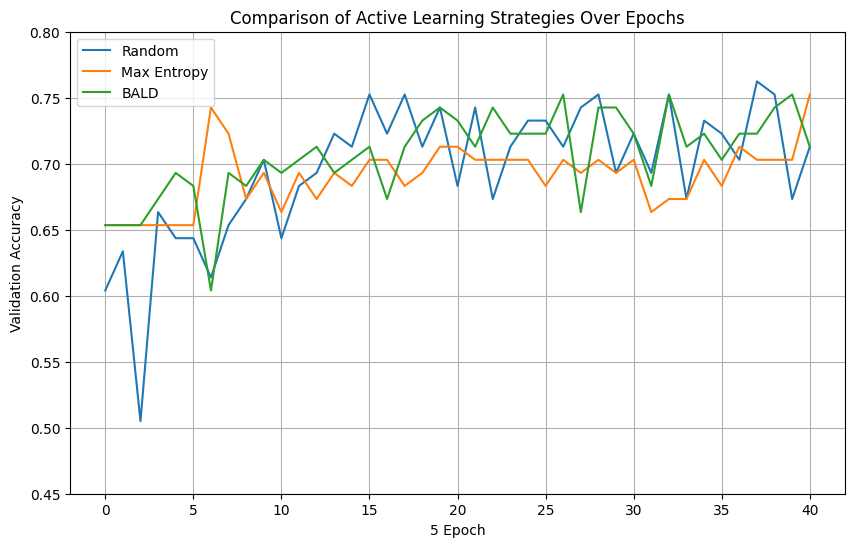

In [659]:
import matplotlib.pyplot as plt

# Assuming you have different strategies you are comparing
plt.style.use('default')
strategy_data = {"Random": uniform_acc[0:201:5], "Max Entropy": max_entropy_acc[0:201:5], "BALD": BALD_acc[0:201:5]}
plt.figure(figsize=(10, 6), facecolor='white')  # Set the background color of the plot figure to white
ax = plt.subplot(111)
ax.set_facecolor('white')
for strategy, accuracies in strategy_data.items():
    print(len(accuracies))
    plt.plot(range(len(accuracies)), accuracies, label=strategy)

plt.title('Comparison of Active Learning Strategies Over Epochs')
plt.xlabel('5 Epoch')
plt.ylim(0.45, 0.8)
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()